In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import math
import scipy.optimize as optimize
from scipy import integrate
from matplotlib import rcParams

In [2]:
#Define parameters from Elowitz paper
alpha_ptc = 0.024;
gamma_p = 0.006;
gamma_c = 0.1539;
K_h = 2.2771;
k_off = 0.3018;
k_on = K_h * k_off;
K_p = 0.5660;
n_p = 0.9;
alpha_R = 0.3908;
gamma_R = 0.002;
K_R = 8.5184;
n_R = 1.5735;
alpha_GBS = 5.6881e-3;
alpha_GBS0 = 9.8715e-5;
D_diff = 58.3931;
alpha_HH = 0.5431;
gamma_H = 8.1346e-4;
beta = 36;
m = 1.8657;

In [23]:
print(alpha_R/ gamma_R)
print(K_p**n_p)

195.39999999999998
0.5991489300104573


P = 4(1+36(29.10169999684341/(29.10169999684341+(195.39999999999998((P^0.9)/((P^0.9) + 0.5991489300104573)))^1.5735)))

R = 195.39999999999998((5.25874^0.9)/((5.25874^0.9) + 0.5991489300104573))

gives us:

P = 5.25874

R = 172.23357

In [15]:
def d_matrix(n):
    h = 1/(n-1)
    D = (-2*np.identity(n))/(h**2)
    for i in range(n-1):
        D[i, i+1] = 1/(h**2)
        D[i+1, i] = 1/(h**2)
    D[-1] = 0
    return D;

In [16]:
diff_mat = d_matrix(1000);

def delta_H(H, P, C, t): 
    del_H = D_diff*np.matmul(diff_mat, H) - gamma_H*H - k_off*H*P + k_on*C;
    for i in range(len(H)):
        if H[i] + (del_H[i] * t) < 0:
            del_H[i] = -H[i]/t;
    #alter boundary conditions
    del_H[0] += alpha_HH;         
    del_H[-1] = 0;
    return del_H;

def phi_R(R, n):
    phi = np.zeros(n)
    for i in range(n):
        phi[i] = (K_R**n_R)/((K_R**n_R)+(R[i]**n_R))
    return phi;

def delta_P(H, P, R, C, t):
    n = len(H);
    delta = (alpha_ptc*np.ones(n)) + (alpha_ptc*beta*phi_R(R, n)) - (gamma_p*P) - (k_on*H*P) + (k_off*C)
    for i in range(n):
        if P[i] + (delta[i]*t) < 0:
            delta[i] = -P[i]/t;
    return delta;

def delta_C(H, P, C, t):
    n = len(H);
    delta = (k_on*H*P) - (k_off*C) - (gamma_c*C)
    for i in range(n):
        if C[i] + (delta[i]*t) < 0:
            delta[i] = -C[i]/t;
    return delta;

def delta_R(P, R, t):
    n = len(P);
    delta = np.zeros(n)
    for i in range(n):
        delta[i] = (alpha_R*(P[i]**n_p)/((K_p**n_p)-(P[i]**n_p))) - (gamma_R*R[i])
    for i in range(n):
        if R[i] + (delta[i]*t) < 0:
            delta[i] = -R[i]/t;
    return delta;

def delta_S(R, S, t):
    n = len(R);
    delta = (alpha_GBS0*np.ones(n)) - (alpha_GBS*phi_R(R, n))
    for i in range(n):
        if S[i] + (delta[i]*t) < 0:
            delta[i] = -S[i]/t;
    return delta;

In [17]:
#define our model function to pass into odeint
def model(t, varlist):
    varlist_mat = varlist.reshape(1000, 5);
    #get the values from varlist. This order corresponds to the order in which we passed in the variables to odeint
    h_vals = varlist_mat[:, 0];
    p_vals = varlist_mat[:, 1];
    c_vals = varlist_mat[:, 2];
    r_vals = varlist_mat[:, 3];
    s_vals = varlist_mat[:, 4];
    
    t = 10**(-3);
    delta_h = delta_H(h_vals, p_vals, c_vals, t);
    delta_p = delta_P(h_vals, p_vals, r_vals, c_vals, t);
    delta_c = delta_C(h_vals, p_vals, c_vals, t);
    delta_r = delta_R(p_vals, r_vals, t);
    delta_s = delta_S(r_vals, s_vals, t);
        
    deltas_list = np.array([delta_h, delta_p, delta_c, delta_r, delta_s]); #list to store the deltas for each variable at each x-position

    return deltas_list.reshape(5000,);
    

In [18]:
def integrate_system(final_time, n):
    #vectors for H, C, S are zeroes at start
    H = np.zeros(n);
    C = np.zeros(n);
    S = np.zeros(n);
    #for each P and R are the same. Calculated analytically at steady-state
    P = 23.2376*np.ones(n)
    R = 188.735*np.ones(n)

    time = np.arange(0, final_time, 10**-7);
    start_vals = np.array([H, P, C, R, S]).reshape(5000,);
    t0 = 0;
    
#     print(start_vals.shape)
#     results = integrate.odeint(model, start_vals, time)
    o = integrate.ode(model).set_integrator('vode', method='bdf', order=15);
    o.set_initial_value(start_vals, t0); #set the start values
    
    dt = 10**(-5);
    timepoints = [];
    results = [];
    while o.successful() and o.t < final_time: #keep looping while time for model is less than the final time
        o.integrate(o.t + dt); #integrate for next time point
        timepoints.append(o.t); #get the exact time for new time point 
        results.append(o.y.reshape(1000,5)); #get the values for each protein at each point
    
    return np.array(results);

In [19]:
results = integrate_system(10, 1000)
results.shape

/Users/bhavenpatel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/Users/bhavenpatel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
/Users/bhavenpatel/anaconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1009: UserWarning: vode: Repeated convergence failures. (Perhaps bad Jacobian supplied or wrong choice of MF or tolerances.)
  self.messages.get(istate, unexpected_istate_msg)))


(1, 1000, 5)

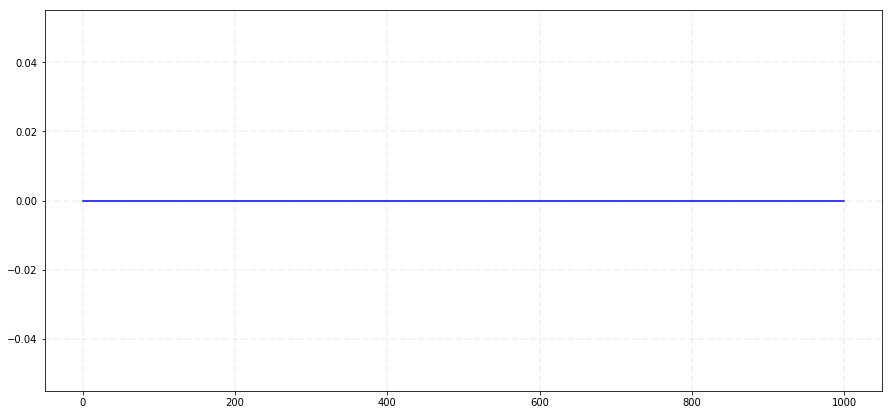

In [44]:
last_time = results[-1].reshape(1000,5);

fig, ax = plt.subplots(figsize=(15, 7))
ax.grid(True, lw=1.76, ls='--', alpha = 0.15)
plt.plot(last_time[:,4], '', color = 'b', ms =10)
plt.show()